In [4]:
% load_ext autoreload
% autoreload 2
import os
import sys

import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier

import imodels
from imodels.util.data_util import get_clean_dataset

sys.path.append('..')

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# change working directory to project root
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../..')
from config.saps.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from viz import *
import viz
from util import DATASET_PATH

print('num_datasets', len(DATASETS_CLASSIFICATION), len(DATASETS_REGRESSION))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
num_datasets 11 9


# overarching plots

100%|██████████| 6/6 [00:00<00:00,  7.29it/s]


<Figure size 648x360 with 0 Axes>

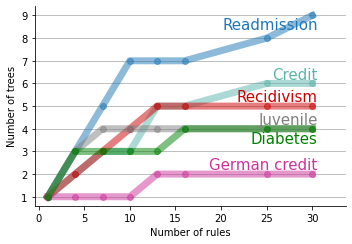

In [2]:
num_dsets = 6
datasets = DATASETS_CLASSIFICATION[::-1][:6]  #+ DATASETS_REGRESSION[::-1]

R, C = ceil(num_dsets / 3), 3
plt.figure(figsize=(3 * C, 2.5 * R), facecolor='w')

COLORS = [cb, cg, cr, 'gray', cp, 'green']
COLORS = COLORS + COLORS + COLORS
plt.figure(figsize=(5, 3.5))
for i, dset in enumerate(tqdm(datasets)):
    dset_name = dset[0]

    pkl_file = oj('../results', 'reg_data', dset_name, 'train-test/combined.pkl')
    data = pkl.load(open(pkl_file, 'rb'))  #['df']

    rules = data['rule_df']
    rules['model'] = rules.index
    rules.index = np.arange(rules.shape[0])

    df = data['df']
    df['model'] = df.index
    df.index = np.arange(df.shape[0])

    cols_to_use = df.columns.difference(rules.columns)
    d = rules.join(df[cols_to_use])

    g = d[d.model == 'SAPS']
    name = 'SAPS'
    est_params = g[dset_name]
    trees = [x[0] for x in est_params]
    n_trees = np.array([len(t) for t in trees])

    x = g[f'{dset_name}_complexity'].values

    plt.plot(x, n_trees, 'o-',
             alpha=0.5,
             label=dset_name.capitalize().replace('-', ' '), color=COLORS[i], lw=7)
    plt.ylabel('Number of trees')
    plt.xlabel('Number of rules')

dvu.line_legend(adjust_text_labels=True)
plt.grid(axis='y')
viz.savefig('num_trees')

# look at some specific models

In [56]:
# dset = ("diabetes", "diabetes", "pmlb")
dset = ("credit", oj(DATASET_PATH, "credit_card/credit_card_clean.csv"), 'local')

dset_name = dset[0]

pkl_file = oj('../results', 'reg_data', dset_name, 'train-test/combined.pkl')
data = pkl.load(open(pkl_file, 'rb'))  #['df']

rules = data['rule_df']
rules['model'] = rules.index
rules.index = np.arange(rules.shape[0])

df = data['df']
df['model'] = df.index
df.index = np.arange(df.shape[0])

cols_to_use = df.columns.difference(rules.columns)
d = rules.join(df[cols_to_use])

g_saps = d[d.model == 'SAPS']
g_cart = d[d.model == 'CART']

In [70]:
X, y, feature_names = get_clean_dataset(dset[1], data_source=dset[2])
print(feature_names)

['limit_bal', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'sex:1', 'sex:2', 'education:0', 'education:1', 'education:2', 'education:3', 'education:4', 'education:5', 'education:6', 'marriage:0', 'marriage:1', 'marriage:2', 'marriage:3']


compare SAPS and CART for this data

In [86]:
g_saps[[f'{dset_name}_complexity', f'{dset_name}_rocauc_test', f'{dset_name}_accuracy_test']]

,credit_complexity,credit_rocauc_test,credit_accuracy_test
0,1,0.651416,0.829500
1,4,0.744080,0.827333
2,7,0.766156,0.827333
3,10,0.771283,0.826667
4,13,0.775311,0.827833
5,16,0.774751,0.826667
6,25,0.778638,0.828000
7,30,0.779150,0.826667


In [85]:
g_cart[[f'{dset_name}_complexity', f'{dset_name}_rocauc_test', f'{dset_name}_accuracy_test']]

,credit_complexity,credit_rocauc_test,credit_accuracy_test
16,1,0.651416,0.829500
17,3,0.695146,0.829500
18,7,0.733311,0.826333
19,15,0.750436,0.825667
20,31,0.760595,0.826167


In [73]:
model_num = 1
m = imodels.SaplingSumRegressor()
m.trees_ = g_saps[dset_name].iloc[model_num][0]

In [77]:
name_remapping = {
    'X_' + str(i): feature_names[i]
    for i in range(len(feature_names))
}
s = str(m)
for x in name_remapping.keys():
    s = s.replace(x, name_remapping[x])
print(s)

------------
pay_0 <= 1.500 (Tree #0 root)
	pay_2 <= 1.500 (split)
		age5 <= 1500.500 (split)
			Val: 0.203 (leaf)
			Val: 0.109 (leaf)
		Val: 0.425 (leaf)
	Val: 0.688 (leaf)

	+
pay_5 <= 1.000 (Tree #1 root)
	Val: -0.012 (leaf)
	Val: 0.109 (leaf)



In [80]:
model_num_cart = 2
t = DecisionTreeClassifier()
t.classes_ = ['0', '1']
t.tree_ = g_cart.iloc[model_num_cart][dset_name]

In [82]:
print(export_text(t, feature_names=feature_names))
# plot_tree(t, feature_names=feature_names)
# plt.show()

|--- pay_0 <= 1.50
|   |--- pay_2 <= 1.50
|   |   |--- pay_amt2 <= 1500.50
|   |   |   |--- class: 0
|   |   |--- pay_amt2 >  1500.50
|   |   |   |--- class: 0
|   |--- pay_2 >  1.50
|   |   |--- pay_6 <= 1.00
|   |   |   |--- class: 0
|   |   |--- pay_6 >  1.00
|   |   |   |--- class: 1
|--- pay_0 >  1.50
|   |--- pay_6 <= 1.00
|   |   |--- bill_amt1 <= 2207.50
|   |   |   |--- class: 0
|   |   |--- bill_amt1 >  2207.50
|   |   |   |--- class: 1
|   |--- pay_6 >  1.00
|   |   |--- bill_amt6 <= 984.00
|   |   |   |--- class: 0
|   |   |--- bill_amt6 >  984.00
|   |   |   |--- class: 1



# look at model example

In [5]:
t = DecisionTreeClassifier()


In [9]:
X, y, feature_names = get_clean_dataset('iai_pecarn', 'imodels', DATASET_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
t.fit(X_train, y_train)

DecisionTreeClassifier()

In [14]:
vars(t)

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'n_features_in_': 58,
 'n_outputs_': 1,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 'max_features_': 58,
 'tree_': <sklearn.tree._tree.Tree at 0x12e7676b0>}

In [ ]:
k
